In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [330]:
import datetime as dt
from pprint import pprint
import seaborn as sns

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Explore the data

In [12]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [110]:
# Get the max date in Measurement > date
# engine.execute('SELECT * FROM measurement order by date DESC').fetchall()
maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
maxdate = list(np.ravel(maxdate))[0]
maxdate

'2017-08-23'

In [117]:
#Strip max date to manipulate and define the date 12months before max date

maxdate2 = dt.datetime.strptime(maxdate, "%Y-%m-%d")
maxdate2 = maxdate2.timetuple()
# maxdate2
year = maxdate2[0]-1
month = maxdate2[1]
day = maxdate2[2]
last12m = dt.date(year, month, day)
last12m

datetime.date(2016, 8, 23)

In [251]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

last12m_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last12m).all()
# last12m_query

last12m_df = pd.DataFrame(last12m_query)
last12m_df = last12m_df.dropna()
last12m_df = last12m_df.sort_values('date', ascending =False)
last12m_df = last12m_df.set_index('date', drop=False)
last12m_df = last12m_df.rename(columns={'prcp': 'precipitation'})
last12m_df.head(10)

,date,precipitation
date,,
2017-08-23,2017-08-23,0.45
2017-08-23,2017-08-23,0.08
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00
2017-08-22,2017-08-22,0.00
2017-08-22,2017-08-22,0.00
2017-08-22,2017-08-22,0.50
2017-08-21,2017-08-21,0.00
2017-08-21,2017-08-21,0.56


In [247]:
date = last12m_df['date'].tolist()
precipitation = last12m_df['precipitation'].tolist()

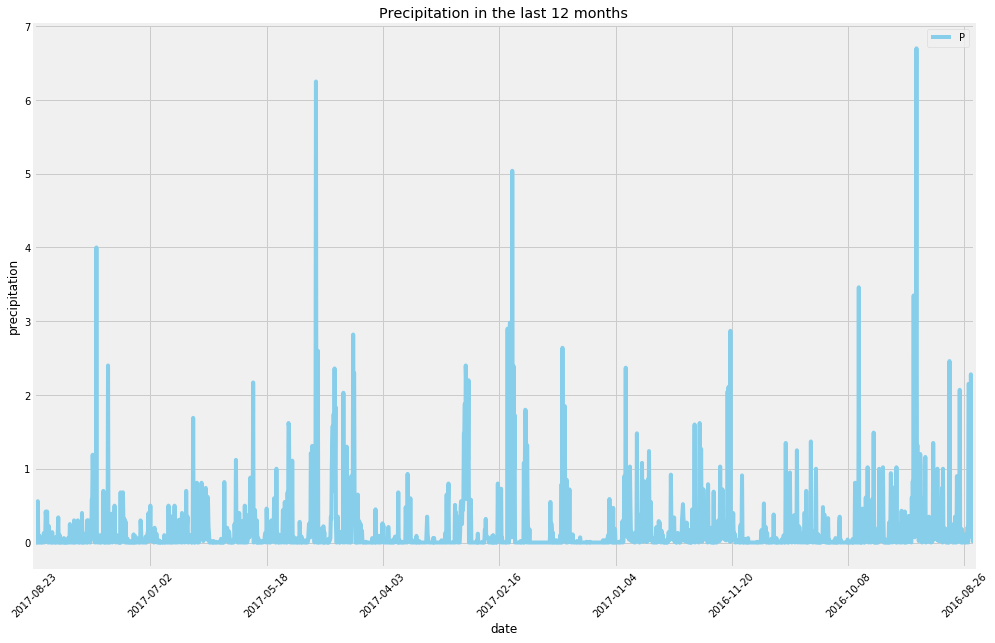

In [249]:
# Use Pandas Plotting with Matplotlib to plot the data

# plt.figure(figsize = (15,10))
# last12m_df.plot(color='skyblue')
# plt.bar(dates, Precipitation)
# plt.title("Precipitation in the last 12 months")

fig, ax = plt.subplots(figsize = (15, 10))
last12m_df.plot(ax = ax, color='skyblue')
ax.set_xlabel('date')
ax.set_ylabel('precipitation')
ax.set_title("Precipitation in the last 12 months")
plt.xticks(rotation='45')
plt.legend('Precipitation')

# Save the Figure
plt.savefig("Precipitation_DD.png")

# Show the Figure
plt.show()

In [252]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12m_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [217]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).group_by(Station.station).all()
count = 0
for station in stations:
    count += 1
    print (station)
print ("-----------------------------")
print(f"There are {count} stations in this dataset")

('USC00511918',)
('USC00513117',)
('USC00514830',)
('USC00516128',)
('USC00517948',)
('USC00518838',)
('USC00519281',)
('USC00519397',)
('USC00519523',)
-----------------------------
There are 9 stations in this dataset


In [209]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations2 = session.query(Measurement.station, func.count(Measurement.tobs))\
.group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
stations2

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [225]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostactive_station = 'USC00519281'

St_highest = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == mostactive_station).first()

St_lowest = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == mostactive_station).first()

St_average = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == mostactive_station).first()

highest_ = list(np.ravel(St_highest))[0]
lowest_ = list(np.ravel(St_lowest))[0]
average_ = list(np.ravel(St_average))[0]

print(f" The lowest temperature recorded in {mostactive_station} station was {lowest_}")
print(f" The highest temperature recorded in { mostactive_station} station was {highest_}")
print(f" The average temperature for {mostactive_station} Station was {average_}")

 The lowest temperature recorded in USC00519281 station was 54.0
 The highest temperature recorded in USC00519281 station was 85.0
 The average temperature for USC00519281 Station was 71.66378066378067


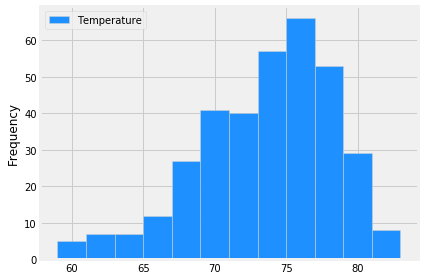

In [257]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactive_station = 'USC00519281'

results = session.query(Measurement.tobs).\
    filter(Measurement.station == mostactive_station).\
    filter(Measurement.date >= last12m).all()

TempTopSt = pd.DataFrame(results, columns=['Temperature'])
TempTopSt.head()


TempTopSt.plot.hist(bins=12, color='dodgerblue', ec='lightgray')
plt.tight_layout()

# Save the Figure
plt.savefig("Histogramn_DD.png")

# Show the Figure
plt.show();

In [258]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [288]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Using trip between 2016-08-01 to 2016-08-23
trip = calc_temps('2016-08-01', '20161-08-23')
# tmin = trip [0][0]
# tavg = trip [0][1]
# tmax = trip [0][2]
# print(tmin, tavg, tmax)

trip_df = pd.DataFrame({'tmin': trip[0][0], 'tmax': trip[0][1], 'tavg': trip[0][2]}, index=[0])
trip_df


,tmin,tmax,tavg
0,60.0,75.748718,84.0


Text(8.185000000000002, 0.5, 'Temperature')

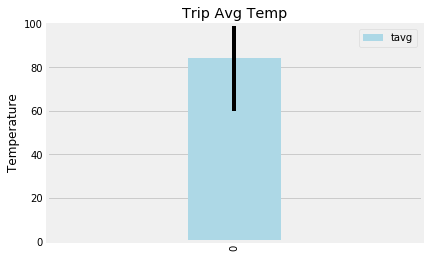

In [291]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
errorbar = tmax-tmin
# plt.bar(0,tavg, yerr=errorbar/2, color = 'lightblue')
trip_df.plot.bar(y='tavg',yerr=errorbar, color='lightblue')
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature')

# save figure:
plt.savefig('average_trip_temperature_DD.png')



In [298]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Using trip between 2016-08-01 to 2016-08-23
start_date = dt.date(2016,8,1)
end_date = dt.date(2017,8,23)

station_data = [Station.station, Station.name,Station.latitude,Station.\
        longitude,Station.elevation,func.sum(Measurement.prcp)]


rainfall = session.query(*station_data).filter(Measurement.station==Station.station).\
        filter(Measurement.date>=start_date).\
        filter(Measurement.date<=end_date).\
        group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall



[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  161.76000000000002),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  80.06000000000006),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  54.39000000000004),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  40.14),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  34.499999999999986),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  17.23999999999999),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.77)]

## Optional Challenge Assignment

In [299]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

# calculate the daily normals for your trip
#push each tuple of calculations into a list called `normals`
#Set the start and end date of the trip
#Use the start and end date to create a range of dates
#Stip off the year and save a list of %m-%d strings
#Loop through the list of %m-%d strings and calculate the normals for each date

In [337]:
# Using trip between 2016-08-01 to 2016-08-23
daily_n = []
dn=0
dates = []
for day in range (1,24):
    if day < 10:
        dn = daily_normals(f"08-0{day}")
        daily_n.append(list(np.ravel(dn)))
        dates.append(f"2016-08-0{day}")
    else: 
        dn = daily_normals(f"08-{day}")
        daily_n.append(list(np.ravel(dn)))
        dates.append(f"2016-08-{day}")
                                     
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
                                    
daily_n_df = pd.DataFrame(list(daily_n), columns=['tmin','tavg','tmax'])
daily_n_df['dates'] = dates                                
daily_n_df = daily_n_df.set_index('dates')
daily_n_df.head(5)

,tmin,tavg,tmax
dates,,,
2016-08-01,67.0,75.540000,83.0
2016-08-02,68.0,75.603774,84.0
2016-08-03,70.0,76.611111,85.0
2016-08-04,69.0,76.711538,84.0
2016-08-05,69.0,76.148148,82.0


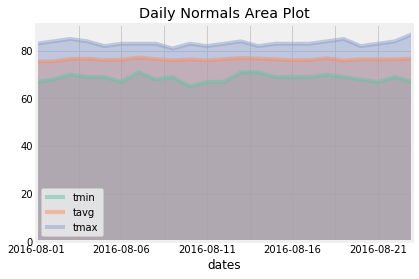

In [360]:
# Plot the daily normals as an area plot with `stacked=False`
pal = sns.color_palette("Set2")
daily_n_df.plot(kind='area', stacked=False, alpha=0.5,color=pal,
        title='Daily Normals Area Plot')
[ax.legend(('tmin','tavg','tmax'),
           loc='lower left') for ax in plt.gcf().axes]

# Save the Figure
plt.savefig("Daily_Normals_DD.png")


plt.show()